<a href="https://colab.research.google.com/github/af001/Northwestern-MSDS/blob/master/MSDS458/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install scipy==1.1.0
!pip3 install git+https://github.com/raghakot/keras-vis.git


  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-hc0jwzyg
  Running command git clone -q https://github.com/raghakot/keras-vis.git /tmp/pip-req-build-hc0jwzyg
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38887 sha256=0af3ef62a46c0565f544ba597a22d9545a340e6e5b0f30cb49cadcc95ab6bae8
  Stored in directory: /tmp/pip-ephem-wheel-cache-jiby3hnc/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis


[+] Running...

[+] Training Data:
   0    1    2    3    4    5    6    ...  778  779  780  781  782  783  784
0    2    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
1    4    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
2    3    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
3    2    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
4    3    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
5    3    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
6    4    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
7    1    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
8    4    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
9    2    0    0    0    0    0    0  ...    0    0    0    0    0    0    0

[10 rows x 785 columns]

[+] Testing Data:
   0    1    2    3    4    5    6    ...  778  779  780  781  782  783  7

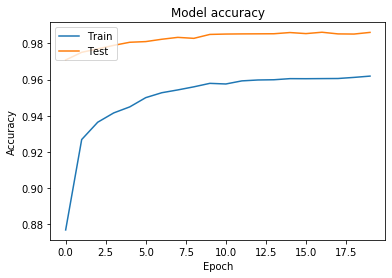

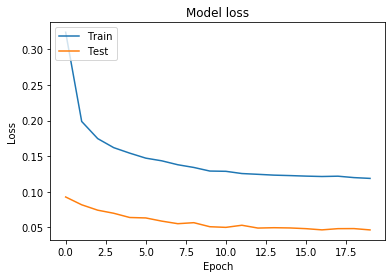

 > showing test image

[+] Layer Details:
 > Conv2D Layer
 > MaxPool2D Layer
 > Dropout Layer
 > Conv2D Layer
 > MaxPool2D Layer
 > Dense Layer
 > Dense Layer - Output


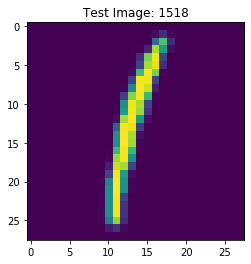

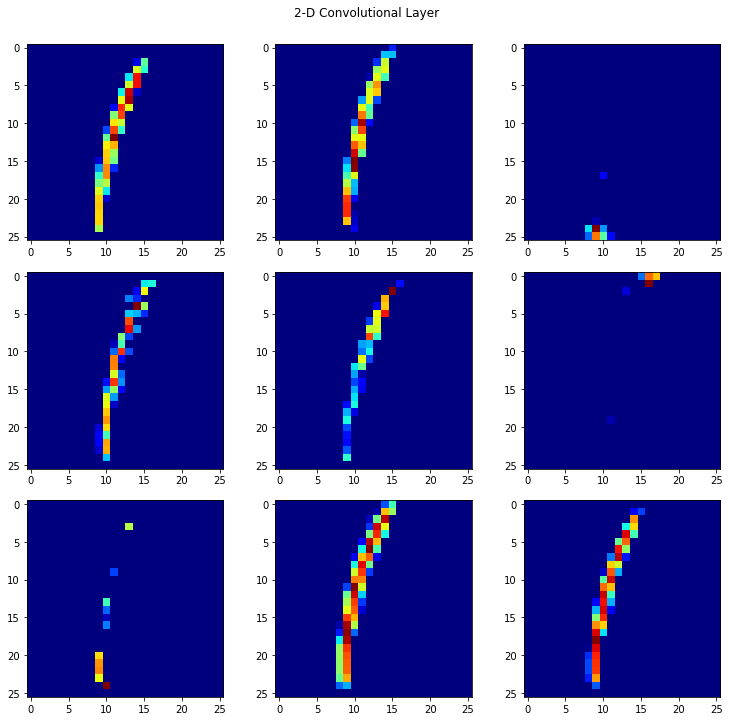

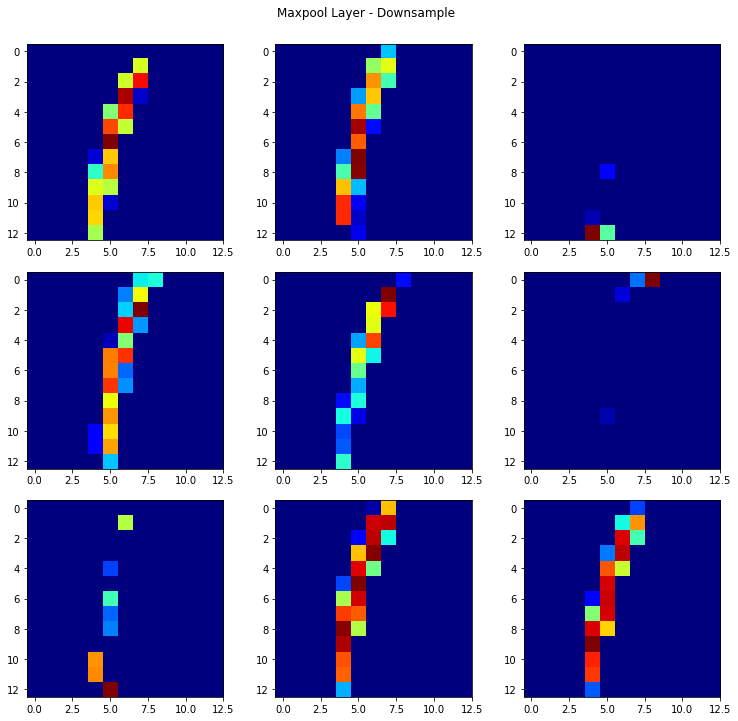

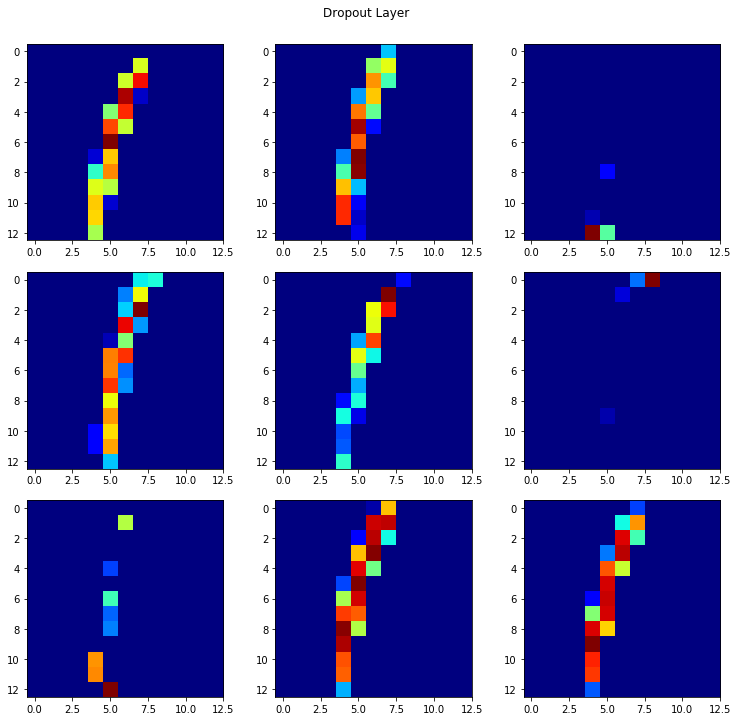

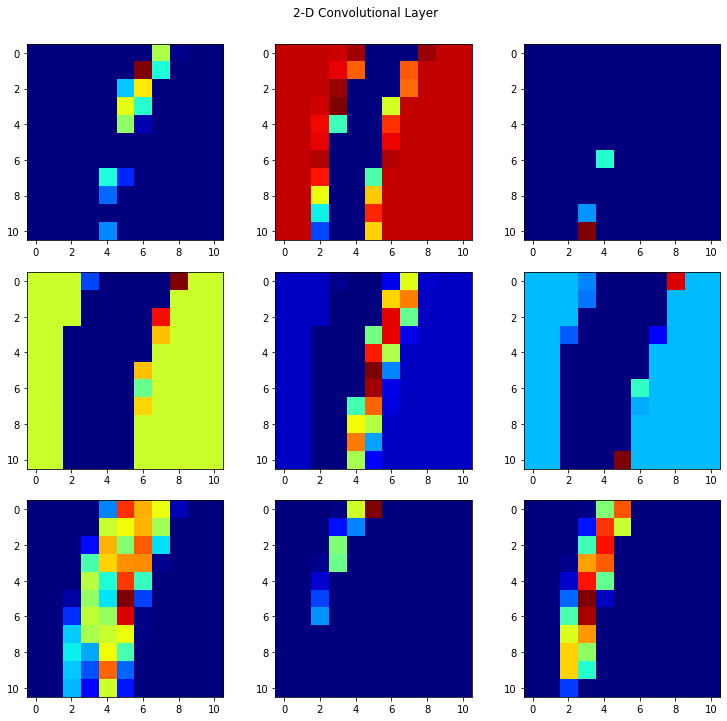

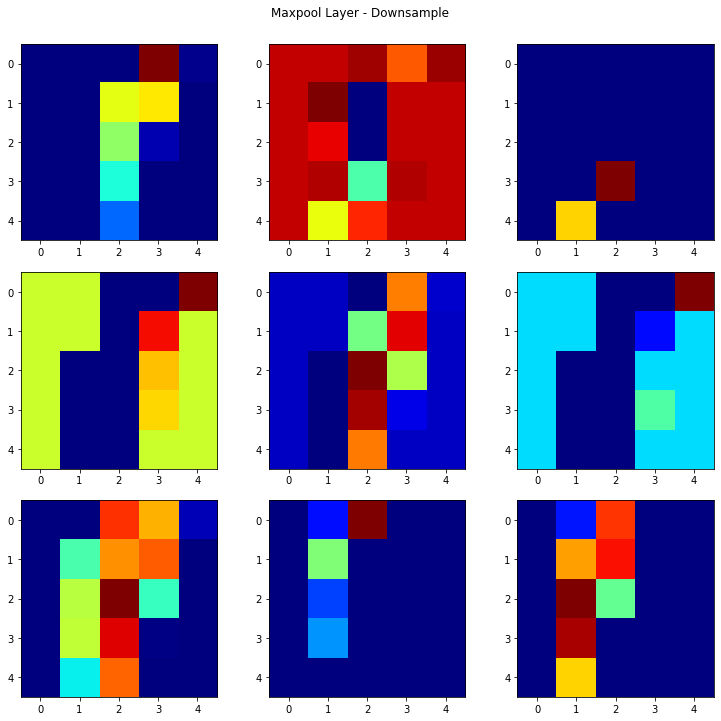

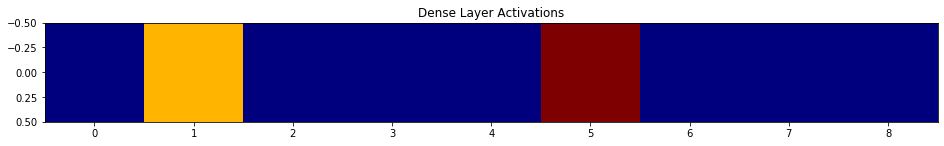

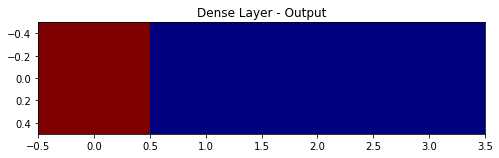

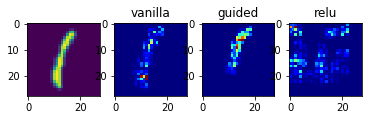

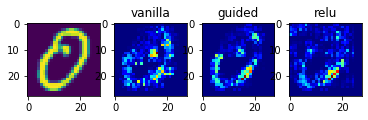

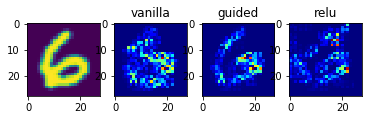

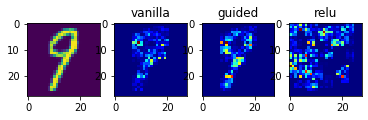

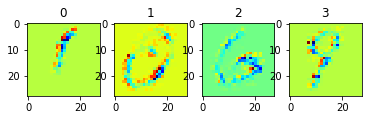

In [3]:
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#                                  ABOUT
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
'''
@author     : Anton Foltz
@class      : MSDS 458
@professor  : Dr. Maren
@date       : 02 November 2018
@descripton : The intent of this assignment is to develop a multi-hidden 
              layer neural network to examine how hidden nodes learn to extract 
              features from their inputs
@references : https://github.com/raghakot/keras-vis
              https://keras.io/

'''
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#                             LIBRARY IMPORTS
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

import keras
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#                           GLOBAL VARIABLES
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Set batch size and epochs for training. The digits 0-9 were divided into
# 4 classes wased on common features
BATCH_SIZE = 64
NUM_CLASSES = 4
EPOCHS = 20
CONV2D_LAYERS = 9
DENSE_LAYERS = 9
LEARNING_RATE = 0.001
EPSILON = None
DECAY = 0.0
TEST_IMAGE = random.randint(0,3999)  # Random pick from test images

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#                             FUNCTIONS
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Display the activations as an image for each layer that is 
# fed into the function
def display_activation(activations, col_size, row_size, act_index, title): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*3.5,col_size*3.5))
    fig.suptitle(title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    for row in range(0,row_size): 
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='jet')
            activation_index += 1

# Read the test and training data from file. Files are stored as csv.
def get_data():
    train_data_path = 'train_digits.csv'
    test_data_path = 'test_digits.csv'
    
    # Use python-mnist library to import pre-shuffled EMNIST letters into Pandas
    train_data = pd.read_csv(train_data_path, header=None)
    test_data = pd.read_csv(test_data_path, header=None)
    
    return (train_data, test_data)

# Verify the data for training and test datasets
def show_details(train_data, test_data):
    print('\n[+] Training Data:')
    print(train_data.head(10))
    print('\n[+] Testing Data:')
    print(test_data.head(10))

# Extract labels and flatten into a 1D array
def extract_labels(data):
    y_train = data[:,:1]
    y_train = np.array(list(map(lambda x: x-1, y_train.flatten())))
    x_train = data[:,1:]
    return(x_train, y_train)

# Transpose the data    
def transpose_data(data):
    return np.array(list(map(lambda x: x.reshape(28,28).transpose(), data)))

# Reshape the data, set type as float32, and normalize
def reshape_xdata(x_train, x_test):
    # Reshape the data for CNN - (x,x,1)
    x_train = np.array(list(map(lambda x: x.reshape(28,28,1) ,x_train)))
    x_test = np.array(list(map(lambda x: x.reshape(28,28,1) ,x_test)))
    print(' > reshaping data for CNN')
    
    # Cast values to float. Pixel values should range from 0 to 255 so convert RGB codes
    # by dividing by 255
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    
    print('\n[+] Samples')
    print(' > training samples: {}'.format(x_train.shape[0]))
    print(' > testing samples : {}'.format(x_test.shape[0]))
    return(x_train, x_test)

# Create 4 categories, or classes. This is basically one-hot encoding
def gen_categories(y_train, y_test):
    # Convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
    return(y_train, y_test)
    
def handle_model(x_train, y_train, x_test, y_test):
     # Configure the model layers
    # Use sequential model - a linear stack of layers
    # Use 2D convolution layer - spatial convolution over images
    # Use MaxPooling2D layer - max pooling operation for spatial data
    # Use dense - regular densely-connected NN layer
    # Use dropout to prevent overfitting - applies dropout to input using (relu activaton)
    model = Sequential()
    model.add(Conv2D(CONV2D_LAYERS, kernel_size=(3, 3), strides=(1, 1), 
                     activation='relu', input_shape=(28,28,1), name='conv2d1'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='maxpool1'))
    model.add(Dropout(0.5))
    model.add(Conv2D(CONV2D_LAYERS, (3, 3), activation='relu', name='conv2d2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2'))
    model.add(Flatten())
    model.add(Dense(DENSE_LAYERS, activation='relu', name='dense1'))
    model.add(Dropout(0.2))
    
    # Add a dense layer (softmax activation) - Output layer
    model.add(Dense(NUM_CLASSES, activation='softmax', name='preds'))
    
    # Show a summary of the model
    print('\n[+] Model Summary:')
    model.summary()
    
    # Show layer details
    print('\n[+] Layer Details:')
    for layer in model.layers:
        print(' > {}'.format(layer.get_output_at(0).get_shape().as_list()))
    print()
    
    # Configure the learning process. Specify loss method, optimizer, and metrics. 
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=LEARNING_RATE, epsilon=EPSILON, decay=DECAY),
                  metrics=['accuracy'])
    
    # Start training
    history = model.fit(x_train, y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=2,
                        validation_split=0.1)
    
    # Evaluate the model
    score = model.evaluate(x_test, y_test, verbose=0)
    
    print('\n[+] Results:')
    print(' > test loss: {}'.format(score[0]))
    print(' > test accuracy: {}'.format(score[1]))
    
    print(' > model saved to: week4_letters_dnn.h5')
    model.save('week4_letters_dnn.h5')
    
    # Plot training & validation accuracy values
    plt.figure(120)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    # Plot training & validation loss values
    plt.figure(121)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
    return model

# Saliency map of activations. Convert the softmax activation to linear and
# visualize vanilla, guided, and relu modifiers. compute the gradient of 
# the output category with respect to the input image
def show_saliency(model, x_test, y_test, layer_idx):
    # Swap softmax with linear
    model.layers[layer_idx].activation = activations.linear
    model = utils.apply_modifications(model)

    # This corresponds to the Dense linear layer. Show each class with
    # vanilla, guided and relu 

    for class_idx in np.arange(4):    
        indices = np.where(y_test[:, class_idx] == 1.)[0]
        idx = indices[0]
    
        f, ax = plt.subplots(1, 4)
        ax[0].imshow(x_test[idx][..., 0])
        
        for i, modifier in enumerate([None, 'guided', 'relu']):
            grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                       seed_input=x_test[idx], backprop_modifier=modifier)
            if modifier is None:
                modifier = 'vanilla'
            ax[i+1].set_title(modifier)    
            ax[i+1].imshow(grads, cmap='jet')

# Saliency map using guided backprop_modifier and negate grad_modifier.  
# Negate the gradients, thus causing output values to decrease.
def show_negate_saliency(model, x_test, y_test, layer_idx):

    i=0    
    f, ax = plt.subplots(1, 4)
    for class_idx in np.arange(4):   
        
        indices = np.where(y_test[:, class_idx] == 1.)[0]
        idx = indices[0]

        grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                   seed_input=x_test[idx], backprop_modifier='guided', 
                                   grad_modifier='negate')
        ax[i].set_title(class_idx)    
        ax[i].imshow(grads, cmap='jet')
        i+=1

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#                               MAIN
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

def main():
    print('[+] Running...')
    
    # Get the test and training data. Show the first 10 rows for each to 
    # validate the data
    train_data, test_data = get_data()
    show_details(train_data, test_data)

    # Extract values from the pandas dataframe to create a list of values
    train_data = train_data.values
    test_data = test_data.values

    # Extract labels from lists. Lables are the first value in the list
    print('\n[+] Manipulating test and training datasets')
    x_train, y_train = extract_labels(train_data)
    print(' > done extracting labels and flattening training data')
    x_test, y_test = extract_labels(test_data)
    print(' > done extracting labels and flattening test data')

    # Transpose the data
    x_train = transpose_data(x_train)
    x_test = transpose_data(x_test)
    print(' > transpose complete on test and training data')
    
    x_train, x_test = reshape_xdata(x_train, x_test)
    y_train, y_test = gen_categories(y_train, y_test)
    
    # For testing, load a saved CNN to save time. Training over
    # multiple epochs can take some time!
    # model = load_model('week4_letters_dnn.h5')
    
    model = handle_model(x_train, y_train, x_test, y_test)
    
    # Display visualizations for each layer in the CNN using a test image.
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    model_activations = activation_model.predict(x_test[TEST_IMAGE].reshape(1,28,28,1))
    
    # Show a test image that is 28x28
    plt.figure(123)
    plt.title('Test Image: {}'.format(TEST_IMAGE))
    plt.imshow(x_test[TEST_IMAGE].reshape(28,28))
    plt.savefig('digit.png')
    print(' > showing test image')
    
    # Show conv2d1 layer activations
    print('\n[+] Layer Details:')
    print(' > Conv2D Layer')
    display_activation(model_activations, 3, 3, 0, '2-D Convolutional Layer')
    
    # Show activations after downsample
    print(' > MaxPool2D Layer')
    display_activation(model_activations, 3, 3, 1, 'Maxpool Layer - Downsample')
    
    # Show activations after dropout
    print(' > Dropout Layer')
    display_activation(model_activations, 3, 3, 2, 'Dropout Layer')
    
    # Show conv2d2 layer activations
    print(' > Conv2D Layer')
    display_activation(model_activations, 3, 3, 3, '2-D Convolutional Layer')
    
    # Show activations after downsample
    print(' > MaxPool2D Layer')
    display_activation(model_activations, 3, 3, 4, 'Maxpool Layer - Downsample')
    
    # Show Dense layer - post-flatten
    print(' > Dense Layer')
    fig, ax = plt.subplots(1, 1, figsize=(16,20))
    plt.title('Dense Layer Activations')
    ax.imshow(model_activations[6], cmap='jet')
    
    # Show Dense layer activations - output layer
    print(' > Dense Layer - Output')
    fig, ax = plt.subplots(1, 1, figsize=(8,12))
    plt.title('Dense Layer - Output')
    ax.imshow(model_activations[8], cmap='jet')
    
    # Utility to search for layer index by name. 
    # Alternatively we can specify this as -1 since it corresponds to the last layer.
    
    layer_idx = utils.find_layer_idx(model, 'preds')
    
    # Show positive and negative saliency maps
    show_saliency(model, x_test, y_test, layer_idx)
    show_negate_saliency(model, x_test, y_test, layer_idx)
    
if __name__ == "__main__":
    main()